# Preparation

In [ ]:
import os

if not os.path.exists("bach-converted") and not os.path.exists("maestro-v3.0.0"):
    # fluidsynth and pretty_midi have system dependency
    ! sudo apt install -y fluidsynth
    ! pip install --upgrade pyfluidsynth
    ! pip install pretty_midi

In [2]:
# I run this on google colab and sometimes on my local machine
# only download bach if its running on colab, where cuda is available
import subprocess

# Wurzelverzeichnis für MIDI-Dateien
root_dir = 'bach'

# Zielverzeichnis für konvertierte TXT-Dateien
output_dir = 'bach-converted'

if not os.path.exists(output_dir):
    # download all bach pieces and unzip them
    ! wget http://www.bachcentral.com/bach.zip
    ! unzip -qq bach.zip

    # convert all pieces to txt, place them in directory /content/bach-converted
    # ChatGPT made code

    # Erstelle das Zielverzeichnis, falls es nicht existiert
    os.makedirs(output_dir, exist_ok=True)

    file_count = 0

    # Durchlaufe alle Unterordner und Dateien im Wurzelverzeichnis
    for subdir, dirs, files in os.walk(root_dir):
        for file in files:
            # Überprüfe, ob die Datei eine .mid-Datei ist
            if file.endswith('.mid'):
                # Vollständiger Pfad zur .mid-Datei
                midi_file_path = os.path.join(subdir, file)
                # Name der .txt-Datei im Zielverzeichnis
                # txt_file_name = os.path.splitext(file)[0] + '.txt'
                txt_file_name = os.path.splitext(file)[0] + '.mid'

                # Vollständiger Pfad zur .txt-Datei im Zielverzeichnis
                txt_file_path = os.path.join(output_dir, txt_file_name)

                # Führe den midicsv-Befehl aus und speichere die Ausgabe im Zielverzeichnis
                # subprocess.run(['midicsv-1.1/midicsv', midi_file_path, txt_file_path])
                subprocess.run(['cp', midi_file_path, txt_file_path])

        file_count += len(files)
    print(f"Done, converted {file_count} files.")

else:
    print("Skipping download steps, assuming files are already downloaded and dependencies are installed")

--2024-09-24 13:17:31--  http://www.bachcentral.com/bach.zip
Resolving www.bachcentral.com (www.bachcentral.com)... 74.208.236.145, 2607:f1c0:100f:f000::232
Connecting to www.bachcentral.com (www.bachcentral.com)|74.208.236.145|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 741602 (724K) [application/zip]
Saving to: ‘bach.zip’

bach.zip            100%[===================>] 724.22K   543KB/s    in 1.3s    

2024-09-24 13:17:33 (543 KB/s) - ‘bach.zip’ saved [741602/741602]

Done, converted 230 files.


In [3]:
# Wurzelverzeichnis für MIDI-Dateien
root_dir = 'maestro-v3.0.0'

if not os.path.exists(root_dir):
    # download all maestro pieces and unzip them
    ! wget https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
    ! unzip -qq maestro-v3.0.0-midi.zip

--2024-09-24 13:17:34--  https://storage.googleapis.com/magentadata/datasets/maestro/v3.0.0/maestro-v3.0.0-midi.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.4.207, 172.253.118.207, 74.125.200.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.4.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58416533 (56M) [application/octet-stream]
Saving to: ‘maestro-v3.0.0-midi.zip’

maestro-v3.0.0-midi 100%[===================>]  55.71M  16.9MB/s    in 4.0s    

2024-09-24 13:17:38 (14.0 MB/s) - ‘maestro-v3.0.0-midi.zip’ saved [58416533/58416533]



In [ ]:
import json

base_dir = "maestro-v3.0.0/"

# split maestro dataset into train, validation and test set
with open(base_dir + 'maestro-v3.0.0.json', 'r') as f:
    data = json.load(f)

# maestro is already split into train, validation and test set
# get indexes of train, validation and test set
maestro_train_indexes = [i for i, x in data['split'].items() if x == 'train']
maestro_val_indexes = [i for i, x in data['split'].items() if x == 'validation']
maestro_test_indexes = [i for i, x in data['split'].items() if x == 'test']

# get the files of the indexes
maestro_train_files = [base_dir + data['midi_filename'][i] for i in maestro_train_indexes]
maestro_val_files = [base_dir + data['midi_filename'][i] for i in maestro_val_indexes]
maestro_test_files = [base_dir + data['midi_filename'][i] for i in maestro_test_indexes]

print(maestro_train_files)

# Imports and setup

In [5]:
from scipy.special import softmax
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import re
import time
from datetime import datetime

import pretty_midi
import glob
import pathlib
from IPython import display

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
_SAMPLING_RATE = 16000

# cuda is only available on colab for me
if torch.cuda.is_available():
    save_to_drive = True
else:
    save_to_drive = False

In [7]:
# I save the model every epoch on google drive
if save_to_drive:
    from google.colab import drive
    drive.mount('/content/drive')
    MODEL_DIR = f"/content/drive/My Drive/bach-lstm/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    os.makedirs(MODEL_DIR, exist_ok=True)
else:
    MODEL_DIR = f"bach-lstm/{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}"
    os.makedirs(MODEL_DIR, exist_ok=True)


Mounted at /content/drive


In [8]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  """
  Displays a pretty_midi.PrettyMIDI object as audio.
  """
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [9]:
# sample midi
random_file_idx = np.random.randint(0, len(maestro_train_files))
sample_file = maestro_train_files[random_file_idx]
print(sample_file)

pm = pretty_midi.PrettyMIDI(sample_file)

display_audio(pm, seconds=30)


maestro-v3.0.0/2008/MIDI-Unprocessed_06_R2_2008_01-05_ORIG_MID--AUDIO_06_R2_2008_wav--5.midi


In [10]:
def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)
    os.system(f'cp {filename} "{MODEL_DIR}"')

## Create Trainingset

In [11]:
def deinstrumentify(pm: pretty_midi.PrettyMIDI, instrument_amount=None):
    """
    Converts a pretty_midi.PrettyMIDI object to a single instrument object.
    All notes from all instruments are allocated to the new instrument.
    The new instrument is an acoustic grand piano.

    pm: midi file
    instrument_amount: how many instruments should be reduced to 1. If not specified then only piano is used.
    """
    new_instrument = pretty_midi.Instrument(program=0)

    valid_piano_instruments = [
        "Left Hand",
        "Right Hand",
        "Cembalo RH",
        "Cembalo LH"
        "Hammond Organ",
        "Church Organ",
        "Organ",
        "Reed Organ",
        "Great"
    ]

    if not instrument_amount:
        # ideally we would choose the instrument which carries the main melody
        # but this is not trivial since there are lots of pieces
        # where the piano is only accompaning other (melodious) instruments
        # my guess is that we can not filter out the melody instrument algorithmically
        # so we just use the piano
        only_piano = True

    instrument_count = 0
    for instrument in pm.instruments:
        if only_piano and instrument.name not in valid_piano_instruments:
            continue
        for note in instrument.notes:
            new_instrument.notes.append(note)

        instrument_count += 1
        if instrument_count >= instrument_amount:
            break
    return new_instrument

def midi_to_notes(midi_file: str, instrument_amount=None) -> np.ndarray:
    """
    Converts a midi file to a numpy array with the following columns:
    - pitch
    - start
    - duration

    midi_file: path to midi file
    instrument_amount: how many midi instruments should be reduced to a single one
    """
    notes = []
    prev_start = 0

    # print(midi_file)

    try:
        pm = pretty_midi.PrettyMIDI(midi_file)
    except:
        print(f"{midi_file} is broken")
        return np.array([])

    one_track_instrument = pretty_midi.Instrument(program=0)

    if not instrument_amount:
        instrument_amount = 10

    # reduce midi instruments to a single one
    for instrument in pm.instruments[:instrument_amount]:
        for note in instrument.notes:
            one_track_instrument.notes.append(note)

    # sorting is important because otherwise the steps will be miscalculated
    one_track_instrument.notes.sort(key=lambda x: x.start)

    # calculate steps and durations
    for note in one_track_instrument.notes:
        start = note.start
        end = note.end

        pitch = note.pitch
        step = start - prev_start
        duration = end - start
        notes.append([pitch, step, duration])

        if step < 0:
            print(f"step < 0: {step=} {start=} {end=} {duration=} {prev_start=}")

        prev_start = start
    return np.array(notes)

def notes_to_midi(notes: list):
    midi = pretty_midi.PrettyMIDI()
    instrument = pretty_midi.Instrument(program=pretty_midi.instrument_name_to_program('Acoustic Grand Piano'))


    # if notes is a 1D array, convert it to a 2D array
    # this can happen when we want to display a single note
    # since then the notes list is a 1D array
    if torch.tensor(notes).ndim == 1:
        # convert to 2D array
        notes = [notes]


    current_time = 0.0
    for note in notes:
        pitch = int(note[0])
        step = float(note[1])
        duration = float(note[2])
        velocity = 100

        if current_time == 0.0:
            current_time = step
        else:
            current_time += step

        midi_note = pretty_midi.Note(velocity=velocity, pitch=pitch, start=current_time, end=current_time + duration)
        instrument.notes.append(midi_note)

    midi.instruments.append(instrument)
    return midi

In [12]:
key_order = ['pitch', 'step', 'duration']

In [13]:
broken_files = [
    "bach-converted/fugue13.mid",
    "bach-converted/airgstr4.mid",
    "bach-converted/prelude1.mid",
    "bach-converted/fugue12.mid",
    "bach-converted/fugue15.mid",
    "bach-converted/fugue24.mid",
    "bach-converted/fugue19.mid",
    "bach-converted/fugue6.mid",
    "bach-converted/fugue8.mid",
    "bach-converted/prelude2.mid",
    "bach-converted/fugue11.mid"
]

def create_train_notes(
        min_seq_length: int,
        max_seq_length: int,
        file_list: list,
        num_files: int = None,
        instrument_amount: int = None,
        seq_amount: int = 16
        ) -> list:
    """
    Creates a list of sequences from a list of midi files.
    The sequences are created by randomly selecting a start position in the midi file and then selecting a sequence of the given length.
    The sequences are then converted to a numpy array and added to the list of sequences.

    min_seq_length: minimum length of the sequences
    max_seq_length: maximum length of the sequences
    file_list: list of midi files
    num_files: number of files to convert. If None, all files are converted.
    instrument_amount: number of instruments to reduce to. If None, all instruments are reduced to 1.
    seq_amount: number of sequences to create per length.
    """
    if num_files:
        file_list = file_list[:num_files]

    all_sequences = []
    for f in file_list:
        # there are some files that somehow are not readable by pretty_midi
        # they are skipped here
        if f in broken_files:
            continue

        notes = midi_to_notes(f, instrument_amount)

        # midi_to_notes returns an empty array if the file is not readable
        # this is needed since some files aren't broken per se
        # but just don't work regardless
        if not notes.any():
            continue

        for seq_length in range(max_seq_length, min_seq_length, -1):
            for _ in range(seq_amount):
                if (len(notes) - seq_length) <= 0:
                    print(len(notes))
                    print(f)
                start_idx = np.random.randint(0, len(notes) - seq_length)
                seq = notes[start_idx:start_idx + seq_length]
                seq = torch.tensor(seq, dtype=torch.float32)
                all_sequences.append(seq)

    return all_sequences


In [15]:
class NotesDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data
        self.length = len(data)

    def __len__(self):
        return self.length

    def __getitem__(self, index):
        sequence = self.data[index]
        return sequence[:-1], sequence[-1]

In [16]:
def collate_fn(batch):
    sequences, targets = zip(*batch)

    # Berechne die Längen der Sequenzen
    lengths = [len(seq) for seq in sequences]

    # Erstelle gepolsterte Sequenzen
    padded_seqs = nn.utils.rnn.pad_sequence(sequences, batch_first=True)

    # Packe die Sequenzen
    packed_seqs = nn.utils.rnn.pack_padded_sequence(padded_seqs, lengths, batch_first=True, enforce_sorted=False)

    # Konvertiere Ziele zu einem Tensor
    targets = torch.stack(targets)

    return packed_seqs, targets, torch.tensor(lengths)

# Model definition

In [19]:
class BachLSTM(nn.Module):
    def __init__(self, pitch_classes=128, embedding_dim=32, hidden_size=128, num_layers=2, bidirectional=True, num_heads=4):
        super(BachLSTM, self).__init__()

        self.pitch_embedding = nn.Embedding(pitch_classes, embedding_dim)

        lstm_input_dim = embedding_dim + 2  # embedding + step + duration
        self.lstm = nn.LSTM(lstm_input_dim, hidden_size, num_layers=num_layers,
                            batch_first=True, bidirectional=bidirectional)

        self.dropout = nn.Dropout(0.3)

        lstm_output_dim = hidden_size * 2 if bidirectional else hidden_size

        # Add Multi-Head Attention
        self.multihead_attn = nn.MultiheadAttention(lstm_output_dim, num_heads, batch_first=True)

        self.pitch_layer = nn.Linear(lstm_output_dim, pitch_classes)
        self.step_layer = nn.Linear(lstm_output_dim, 1)
        self.duration_layer = nn.Linear(lstm_output_dim, 1)

    def forward(self, x, lengths):
        # Unpack the packed sequence
        x, _ = nn.utils.rnn.pad_packed_sequence(x, batch_first=True)

        # Split input into Pitch, Step and Duration
        x_pitch, x_step, x_duration = x.split(1, dim=-1)

        # Convert Pitch to Long and embed
        x_pitch = x_pitch.long().squeeze(-1)
        pitch_embedded = self.pitch_embedding(x_pitch)

        # Combine all features
        all_features = torch.cat((pitch_embedded, x_step, x_duration), dim=-1)

        # Repack the sequence for LSTM
        packed_input = nn.utils.rnn.pack_padded_sequence(all_features, lengths, batch_first=True, enforce_sorted=False)

        # LSTM processing
        lstm_out, _ = self.lstm(packed_input)
        lstm_out, _ = nn.utils.rnn.pad_packed_sequence(lstm_out, batch_first=True)

        # Apply Multi-Head Attention
        attn_output, _ = self.multihead_attn(lstm_out, lstm_out, lstm_out)

        # Dropout
        attn_output = self.dropout(attn_output)

        # Select the last relevant output
        final_output = attn_output[range(len(lengths)), lengths-1]

        # Final predictions
        pitch = self.pitch_layer(final_output)
        step = self.step_layer(final_output).squeeze(-1)
        duration = self.duration_layer(final_output).squeeze(-1)

        return {
            'pitch': pitch,
            'step': step,
            'duration': duration
        }

# Parameters, Hyperparameters & Dataset


In [20]:
# data hyperparameters
num_epochs = 30
batch_size = 256
feature_length = len(key_order)

# model hyperparameters
hidden_size=1024 # amount of hidden neurons in the lstm
pitch_classes=128
num_layers=1


# loss hyperparameters
weights = {
    'pitch': 1.0,
    'step': 0.75,
    'duration': 0.5
}

pitch_loss = nn.CrossEntropyLoss()
step_loss = nn.MSELoss()
duration_loss = nn.MSELoss()

In [21]:
train_ratio = 0.9
val_ratio = 0.1
test_ratio = 1 - (train_ratio + val_ratio)

In [22]:
# bach dataset
# dataset content
data_dir = "bach-converted/"
all_files = glob.glob(str(pathlib.Path(data_dir)/'**.mid*'))

# filtering out pieces not starting with "fugue" or "prelude"
pattern = r'(fugue|prelude).*\d+\.mid$'
well_tempered_clavier = [f for f in all_files if re.search(pattern, pathlib.Path(f).name)]

# does this model overfit?
# all_files = well_tempered_clavier

bach_train_files = all_files[:int(len(all_files) * train_ratio)]
bach_val_files = all_files[int(len(all_files) * train_ratio):int(len(all_files) * (train_ratio + val_ratio))]
bach_test_files = all_files[int(len(all_files) * (train_ratio + val_ratio)):]

In [23]:
# maestro dataset
# defined in one of the first cells of this file
maestro_train_files = maestro_train_files
maestro_val_files = maestro_val_files
maestro_test_files = maestro_test_files

In [24]:
# get all file indexes composed by "Johann Sebastian Bach" in their name
maestro_bach_indexes = [i for i, x in data['canonical_composer'].items() if x == 'Johann Sebastian Bach']
maestro_bach_files = [base_dir + data['midi_filename'][i] for i in maestro_bach_indexes]

maestro_bach_train_files = maestro_bach_files[:int(len(maestro_bach_files) * train_ratio)]
maestro_bach_val_files = maestro_bach_files[int(len(maestro_bach_files) * train_ratio):int(len(maestro_bach_files) * (train_ratio + val_ratio))]
maestro_bach_test_files = maestro_bach_files[int(len(maestro_bach_files) * (train_ratio + val_ratio)):]

In [25]:
# Dataset creation
files_converted = []
min_seq_length = 8
max_seq_length = 64
num_files = None  # None for all files
instrument_amount = 5
seq_amount = 64

train_notes = create_train_notes(
    min_seq_length=min_seq_length,
    max_seq_length=max_seq_length,
    file_list = bach_train_files, #maestro_train_files, #maestro_bach_train_files
    num_files=num_files,
    instrument_amount=None, # None = only piano
    seq_amount=seq_amount
)

dataset = NotesDataset(train_notes)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [26]:
val_train_notes = create_train_notes(
    min_seq_length=min_seq_length,
    max_seq_length=max_seq_length,
    file_list = bach_val_files, #maestro_val_files, #maestro_bach_val_files
    num_files=num_files,
    instrument_amount=instrument_amount,
    seq_amount=seq_amount
    )
val_dataset = NotesDataset(val_train_notes)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

In [27]:
# Model
model = BachLSTM(hidden_size=hidden_size, pitch_classes=pitch_classes, num_layers=num_layers)
model.to(device)

# optimizer and scheduler
lr_rate = 0.0001
optimizer = torch.optim.AdamW(model.parameters(), lr=lr_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10)

In [28]:
if os.path.exists('model.pth'):
    model.load_state_dict(torch.load('model.pth', map_location=device))
    print("Model loaded from disk")

# Training

In [29]:
def train_step(model, sequences, lengths, targets, weights):
    model.train()
    outputs = model(sequences, lengths)

    pitch = outputs['pitch']
    step = outputs['step']
    duration = outputs['duration']

    pitch_target = targets[:, 0].long()
    step_target = targets[:, 1]
    duration_target = targets[:, 2]

    # additional weight for loss function
    pitch_argmax = torch.argmax(pitch, dim=1)
    pitch_dif = pitch_argmax - pitch_target
    pitch_abs = torch.abs(pitch_dif)
    pitch_sum = torch.sum(pitch_abs)
    pitch_sig = torch.sigmoid(pitch_sum)

    pitch_loss_value = pitch_loss(pitch, pitch_target) * pitch_sig * weights['pitch']
    step_loss_value = step_loss(step, step_target) * weights['step']
    duration_loss_value = duration_loss(duration, duration_target) * weights['duration']

    loss = pitch_loss_value + step_loss_value + duration_loss_value
    return loss

In [30]:
def validate_step(model, sequences, lengths, targets, weights):
    model.eval()
    with torch.no_grad():
        outputs = model(sequences, lengths)

        pitch = outputs['pitch']
        step = outputs['step']
        duration = outputs['duration']

        pitch_loss_value = pitch_loss(pitch, targets[:, 0].long()) * weights['pitch']
        step_loss_value = step_loss(step, targets[:, 1]) * weights['step']
        duration_loss_value = duration_loss(duration, targets[:, 2]) * weights['duration']

        loss = pitch_loss_value + step_loss_value + duration_loss_value
        return loss

In [31]:
model.train()

debug = False

train_losses = []
val_losses = []
lr_rates = []

start_time = time.time()

early_stopping_patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(num_epochs):
    for i, (sequences, targets, lengths) in enumerate(dataloader):
        sequences = sequences.to(device)
        targets = targets.to(device)
        lengths = lengths.to(torch.device("cpu"))

        optimizer.zero_grad()

        loss = train_step(model, sequences, lengths, targets, weights)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        if debug:
            break

    # Set model to evaluation mode
    model.eval()
    with torch.no_grad():
        val_sequences, val_targets, val_lengths = next(iter(val_dataloader))
        val_sequences = val_sequences.to(device)
        val_targets = val_targets.to(device)
        val_lengths = val_lengths.to(torch.device("cpu"))
        val_loss = validate_step(model, val_sequences, val_lengths, val_targets, weights)
    model.train()

    scheduler.step(val_loss)

    train_losses.append(loss.item())
    val_losses.append(val_loss.item())
    lr_rates.append(scheduler.get_last_lr()[0])

    estimated_time = (num_epochs - epoch) * (time.time() - start_time)
    estimated_time = time.strftime("%H:%M:%S", time.gmtime(estimated_time))

    print(f"Epoch {epoch+1:2d}/{num_epochs}, Loss: {loss.item():5f}, Val Loss: {val_loss.item():5f}, LR: {scheduler.get_last_lr()[0]}, Estimated Time: {estimated_time}")

    now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    checkpoint(model, f"model_{epoch+1}-{now}-{num_epochs=}-{batch_size=}-{num_layers=}.pth")

    # Early Stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= early_stopping_patience:
        print("Early stopping triggered")
        break

    if debug:
        break

Epoch  1/30, Loss: 3.301464, Val Loss: 3.615237, LR: 0.0001, Estimated Time: 09:52:11
Epoch  2/30, Loss: 3.057766, Val Loss: 3.466179, LR: 0.0001, Estimated Time: 19:08:17
Epoch  3/30, Loss: 3.013777, Val Loss: 3.362800, LR: 0.0001, Estimated Time: 03:44:20
Epoch  4/30, Loss: 2.869732, Val Loss: 3.282839, LR: 0.0001, Estimated Time: 11:41:12
Epoch  5/30, Loss: 2.758816, Val Loss: 3.280744, LR: 0.0001, Estimated Time: 18:58:19
Epoch  6/30, Loss: 2.588676, Val Loss: 3.360285, LR: 0.0001, Estimated Time: 01:35:50
Epoch  7/30, Loss: 2.343571, Val Loss: 3.457075, LR: 0.0001, Estimated Time: 07:33:38
Epoch  8/30, Loss: 2.078099, Val Loss: 3.463944, LR: 0.0001, Estimated Time: 12:51:31
Epoch  9/30, Loss: 1.783877, Val Loss: 3.630046, LR: 0.0001, Estimated Time: 17:29:52
Epoch 10/30, Loss: 1.452201, Val Loss: 3.917599, LR: 0.0001, Estimated Time: 21:28:42
Early stopping triggered


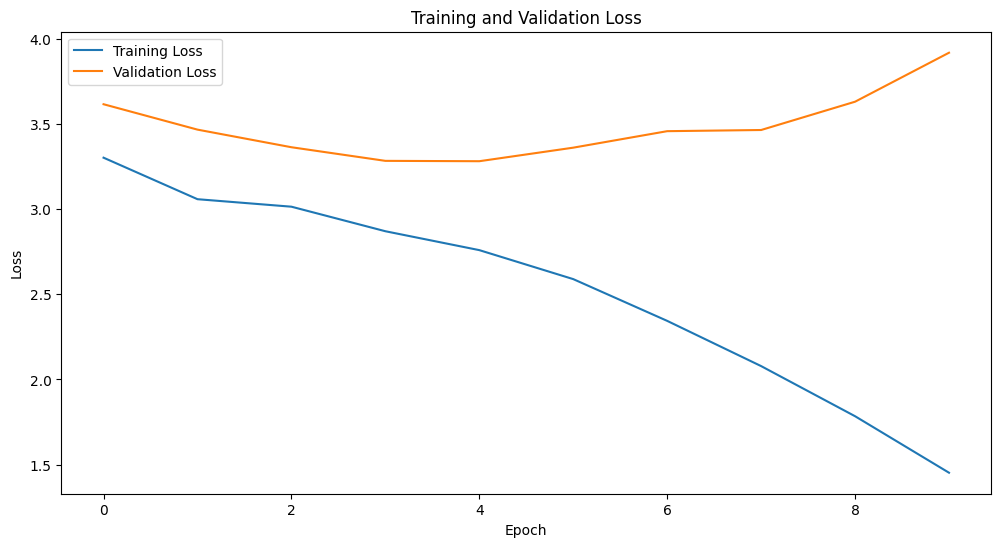

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


In [ ]:
# select best model
epoch = 9
# read file which name starts with model_{epoch}
for file in os.listdir(MODEL_DIR):
    if str(file).startswith(f"model_{epoch}"):
        pretrained_dict = torch.load(MODEL_DIR + file, map_location=device) 
        model.load_state_dict(pretrained_dict)
        break

In [33]:
def sample_evaluation(model, dataloader):
    model.eval()
    for batch in dataloader:
        sequences_packed, targets, lengths = batch
        sequences_packed = sequences_packed.to(device)
        targets = targets.to(device)
        lengths = lengths.to(torch.device("cpu"))
        break

    padded_sequence = torch.nn.utils.rnn.pad_packed_sequence(sequences_packed, batch_first=True)
    with torch.no_grad():
        output = model(sequences_packed, lengths)

        pitch = torch.argmax(output['pitch'], dim=1).unsqueeze(1)
        step = output['step']
        duration = output['duration']

    print("Pitch:        ", end="")
    for p in pitch:
        print(f"{p.item():5d}", end=" ")
    print()

    print("Step:         ", end="")
    for s in step:
        print(f"{s:5.2f}", end=" ")
    print()

    print("Duration:     ", end="")
    for d in duration:
        print(f"{d:5.2f}", end=" ")
    print("\n")

    # compute difference between prediction and target
    pitch_dif = [int(prediction) - int(target) for prediction, target in zip(pitch, targets[:, 0])]
    step_dif = [round(float(prediction) - float(target), 2) for prediction, target in zip(step, targets[:, 1])]
    duration_dif = [round(float(prediction) - float(target), 2) for prediction, target in zip(duration, targets[:, 2])]

    print("Pitch Dif:    ", end="")
    for p in pitch_dif:
        print(f"{p:5d}", end=" ")
    print()

    print("Step Dif:     ", end="")
    for s in step_dif:
        print(f"{s:5.2f}", end=" ")
    print()

    print("Duration Dif: ", end="")
    for d in duration_dif:
        print(f"{d:5.2f}", end=" ")
    print()

    #return pitch_dif, step_dif, duration_dif

In [ ]:
# this function visualizes overfitting
# but if the notes dont match the original its of course no problem
# since the model could have predicted another melody
sample_evaluation(model, dataloader)

In [35]:
def sample_sequence(model, dataloader, num_predictions=50, random=True):
    """
    Sample a random sequence from the dataset, let the model predict the next note and display it.
    If `random` is set to False, the first sequence of the dataloader is used.
    """
    model.eval()

    sequences_packed = []

    for batch in dataloader:
        sequences_packed, _, _ = batch
        sequences_packed = sequences_packed#.to(device)
        if random:
            if np.random.rand() < 0.1:
                break
        else:
            break

    unpacked_sequence, _ = torch.nn.utils.rnn.pad_packed_sequence(sequences_packed, batch_first=True)

    if random:
        idx = np.random.randint(0, len(unpacked_sequence))
    else:
        idx = 0
    sequence = unpacked_sequence[idx]

    for i in range(num_predictions):
        lengths = torch.tensor([len(sequence)])
        lengths = lengths.to('cpu')

        # I don't know why I have to squeeze and unsqueeze sequence
        # this works flawlessly without squeezing on cpu
        # but somehow its needed on cuda
        sequence = sequence.unsqueeze(0)

        pack_t = torch.nn.utils.rnn.pack_padded_sequence(sequence, lengths, batch_first=True, enforce_sorted=False)
        pack_t = pack_t.to(device)

        outputs = model(pack_t, lengths)

        with torch.no_grad():
            # top k sampling
            pitch_sample = torch.topk(outputs['pitch'], k=2)

            # pitch = torch.argmax(outputs['pitch'], dim=1).squeeze(0)
            pitch = pitch_sample.indices.squeeze(0)
            pitch = pitch[np.random.randint(0, len(pitch))]

            step = outputs['step'].squeeze(0)
            duration = outputs['duration'].squeeze(0)

            new_note = torch.tensor([pitch, step, duration]).unsqueeze(0)

            # I don't know why
            sequence = sequence.squeeze(0)

            sequence = torch.cat([sequence, new_note], dim=0)

    return sequence


notes = sample_sequence(model, dataloader, num_predictions=100, random=False)
midi = notes_to_midi(notes.cpu().numpy())
display_audio(midi, seconds=60)


In [38]:
# save model
name = f'model-{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}-{num_epochs=}-{batch_size=}-{num_layers=}.pth'
torch.save(model.state_dict(), f"{MODEL_DIR}/" + name)

# save midi
midi_filename = f'midi_sample_{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}-{num_epochs=}-{batch_size=}-{num_layers=}.mid'
with open(midi_filename, 'wb') as f:
    midi.write(midi_filename)
print(f'MIDI file saved as "{midi_filename}"')

# copy midifile to MODEL_DIR
os.system(f'cp /content/{midi_filename} "{MODEL_DIR}"')

MIDI file saved as "midi_sample_2024-09-24_16-56-57-num_epochs=30-batch_size=256-num_layers=1.mid"


0